In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
import tensorflow as tf
print(tf.__version__)
plt.rc('figure', figsize=(13, 4))

2.6.0


In [2]:
# https://github.com/42io/dataset/tree/master/openslr_musan
DATASET_FILE = '1zR4Llk9SyiEddFrXwDQuaKIr4kYerjOo'

In [3]:
!pip install -qq gdown
!test -f "$DATASET_FILE" || gdown --id "$DATASET_FILE" -O "$DATASET_FILE"

In [4]:
md5 = !md5sum "$DATASET_FILE"
assert '3a65d6a64314e5c343ae52997d078ace' == md5[0].split()[0]

In [5]:
def create_ds(t):
  x = 'x_' + t
  y = 'y_' + t
  d = tf.data.Dataset.from_tensor_slices((dset[x], dset[y]))
  d = d.map(lambda x, y: [tf.cast(x, tf.float32), y])
  d = d.map(lambda x, y: [x, tf.cast(y, tf.bool)])
  d = d.map(lambda x, y: [tf.reshape(x, (49, 13))[1:-1], y])
  d = d.cache()
  return d

In [6]:
dset = np.load(DATASET_FILE)
print(dset['x_train'].shape)

(1825800, 637)


In [7]:
train_dataset = create_ds('train')
test_dataset  = create_ds('test')
valid_dataset = create_ds('valid')
train_dataset.cardinality().numpy()

1825800

In [8]:
def spectrogram_masking(spectrogram, dim=1, masks_number=2, mask_max_size=5):
  """Spectrogram masking on frequency or time dimension.
  Args:
    spectrogram: Input spectrum [batch, time, frequency]
    dim: dimension on which masking will be applied: 1 - time; 2 - frequency
    masks_number: number of masks
    mask_max_size: mask max size
  Returns:
    masked spectrogram
  """
  if dim not in (1, 2):
    raise ValueError('Wrong dim value: %d' % dim)
  input_shape = spectrogram.shape
  time_size, frequency_size = input_shape[1:3]
  dim_size = input_shape[dim]  # size of dimension on which mask is applied
  stripe_shape = [1, time_size, frequency_size]
  for _ in range(masks_number):
    mask_end = tf.random.uniform([], 0, mask_max_size, tf.int32)
    mask_start = tf.random.uniform([], 0, dim_size - mask_end, tf.int32)

    # initialize stripes with stripe_shape
    stripe_ones_left = list(stripe_shape)
    stripe_zeros_center = list(stripe_shape)
    stripe_ones_right = list(stripe_shape)

    # update stripes dim
    stripe_ones_left[dim] = dim_size - mask_start - mask_end
    stripe_zeros_center[dim] = mask_end
    stripe_ones_right[dim] = mask_start

    # generate mask
    mask = tf.concat((
        tf.ones(stripe_ones_left, spectrogram.dtype),
        tf.zeros(stripe_zeros_center, spectrogram.dtype),
        tf.ones(stripe_ones_right, spectrogram.dtype),
    ), dim)
    spectrogram = spectrogram * mask
  return spectrogram

In [9]:
def train_model(model, train_dataset, valid_dataset):

  early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        mode='min',
        verbose=1,
        patience=100,
        restore_best_weights=True)

  train_batch = train_dataset.shuffle(train_dataset.cardinality())
  train_batch = train_batch.batch(128)
  train_batch = train_batch.map(lambda x, y: (spectrogram_masking(x, 1, 3, 3), y))
  train_batch = train_batch.map(lambda x, y: (spectrogram_masking(x, 2, 2, 2), y))
  train_batch = train_batch.prefetch(tf.data.AUTOTUNE)

  valid_batch = valid_dataset.batch(512)
  valid_batch = valid_batch.prefetch(tf.data.AUTOTUNE)

  # plt.imshow(list(train_batch.take(1))[0][0][0].numpy().T)
  # plt.show()

  history = model.fit(train_batch,
                      validation_data=valid_batch,
                      callbacks=[early_stopping],
                      verbose=2,
                      epochs=1000) # play with google colab time limit

  model.set_weights(early_stopping.best_weights)
  return history

In [10]:
# https://arxiv.org/pdf/2005.06720.pdf

def streaming_input_output(streaming, t, inputs, otputs, x):
  if streaming:
    otputs.append(x)
    x = keras.Input(shape=[t] + x.shape[2:])
    inputs.append(x)
  return x

def build_model(streaming=False):

  # resetting the layer name generation counter
  keras.backend.clear_session()

  inputs  = []
  outputs = []

  x_in = keras.Input(shape=[1, 1, 13] if streaming else [47, 13])
  x = x_in if streaming else keras.backend.expand_dims(x_in, -2)

  x = keras.layers.Conv2D(32, 1, use_bias=False)(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.ReLU()(x)
  x = keras.layers.SpatialDropout2D(x.shape[-1]/1280.0)(x)

  for i in range(4):
    x = streaming_input_output(streaming, 2, inputs, outputs, x)
    x = keras.layers.SeparableConv2D(x.shape[-1], kernel_size=[2, 1], 
                                     dilation_rate=[1 if streaming else 2**i, 1], 
                                     use_bias=False)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)
    x = keras.layers.SpatialDropout2D(x.shape[-1]/1280.0)(x)

  x = streaming_input_output(streaming, 32, inputs, outputs, x)
  x = keras.layers.AveragePooling2D([x.shape[1], 1])(x)
  x = keras.layers.Flatten()(x)

  x = keras.layers.Dense(x.shape[-1] // 2, use_bias=False)(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.ReLU()(x)
  x = keras.layers.Dropout(x.shape[-1]/1280.0)(x)

  x = keras.layers.Dense(1)(x)

  model = keras.Model(inputs=[x_in] + inputs, outputs=[x] + outputs)

  return model

In [11]:
model = build_model()
model.summary()
model.compile(
  loss=keras.losses.BinaryCrossentropy(from_logits=True),
  optimizer=keras.optimizers.Adam(),
  metrics=['accuracy']
)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 47, 13)]          0         
_________________________________________________________________
tf.expand_dims (TFOpLambda)  (None, 47, 1, 13)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 47, 1, 32)         416       
_________________________________________________________________
batch_normalization (BatchNo (None, 47, 1, 32)         128       
_________________________________________________________________
re_lu (ReLU)                 (None, 47, 1, 32)         0         
_________________________________________________________________
spatial_dropout2d (SpatialDr (None, 47, 1, 32)         0         
_________________________________________________________________
separable_conv2d (SeparableC (None, 46, 1, 32)         1088  

In [12]:
history = train_model(model, train_dataset, valid_dataset)

Epoch 1/1000
14265/14265 - 384s - loss: 0.0880 - accuracy: 0.9657 - val_loss: 0.0442 - val_accuracy: 0.9860
Epoch 2/1000
14265/14265 - 327s - loss: 0.0541 - accuracy: 0.9802 - val_loss: 0.0374 - val_accuracy: 0.9875
Epoch 3/1000
14265/14265 - 327s - loss: 0.0487 - accuracy: 0.9823 - val_loss: 0.0325 - val_accuracy: 0.9898
Epoch 4/1000
14265/14265 - 327s - loss: 0.0452 - accuracy: 0.9836 - val_loss: 0.0338 - val_accuracy: 0.9882
Epoch 5/1000
14265/14265 - 327s - loss: 0.0437 - accuracy: 0.9842 - val_loss: 0.0306 - val_accuracy: 0.9911
Epoch 6/1000
14265/14265 - 326s - loss: 0.0421 - accuracy: 0.9849 - val_loss: 0.0267 - val_accuracy: 0.9918
Epoch 7/1000
14265/14265 - 326s - loss: 0.0410 - accuracy: 0.9852 - val_loss: 0.0292 - val_accuracy: 0.9911
Epoch 8/1000
14265/14265 - 327s - loss: 0.0400 - accuracy: 0.9855 - val_loss: 0.0285 - val_accuracy: 0.9905
Epoch 9/1000
14265/14265 - 326s - loss: 0.0395 - accuracy: 0.9859 - val_loss: 0.0316 - val_accuracy: 0.9905
Epoch 10/1000
14265/14265 - 

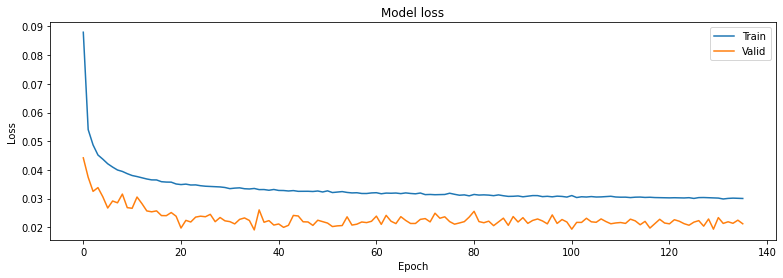

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper right')

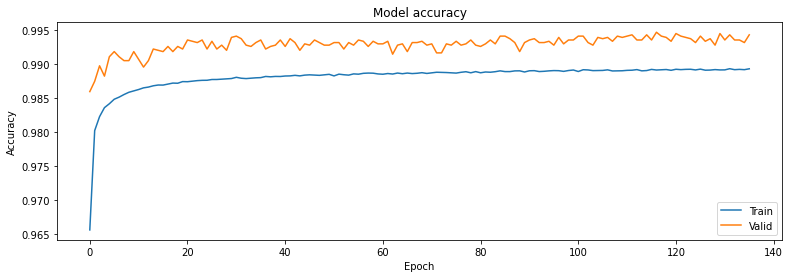

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='lower right')

In [15]:
results = model.evaluate(train_dataset.batch(8192), verbose=0)
print('train loss, train acc:', results)
results = model.evaluate(test_dataset.batch(512), verbose=0)
print('test loss, test acc:', results)
results = model.evaluate(valid_dataset.batch(512), verbose=0)
print('valid loss, valid acc:', results)

train loss, train acc: [0.016179345548152924, 0.9948329329490662]
test loss, test acc: [0.0193141158670187, 0.994413435459137]
valid loss, valid acc: [0.0191042460501194, 0.9935557246208191]


In [16]:
pred = model.predict(test_dataset.batch(512)).squeeze(-1) > 0
print(np.sum(pred != list(test_dataset.map(lambda x, y: y))), test_dataset.cardinality().numpy())
pred = model.predict(valid_dataset.batch(512)).squeeze(-1) > 0
print(np.sum(pred != list(valid_dataset.map(lambda x, y: y))), valid_dataset.cardinality().numpy())

38 6086
33 5276


In [17]:
stream_model = build_model(True)
for layer in stream_model.layers:
  if layer.get_weights():
    print("Transfer weights for layer {}".format(layer.name))
    layer.set_weights(model.get_layer(name=layer.name).get_weights())

Transfer weights for layer dense
Transfer weights for layer batch_normalization_5
Transfer weights for layer conv2d
Transfer weights for layer separable_conv2d
Transfer weights for layer separable_conv2d_1
Transfer weights for layer separable_conv2d_2
Transfer weights for layer separable_conv2d_3
Transfer weights for layer batch_normalization
Transfer weights for layer batch_normalization_1
Transfer weights for layer batch_normalization_2
Transfer weights for layer batch_normalization_3
Transfer weights for layer batch_normalization_4
Transfer weights for layer dense_1


In [18]:
converter = tf.lite.TFLiteConverter.from_keras_model(stream_model)
tflite_model = converter.convert()
with open("dcnn13.bin.tflite", "wb") as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpyjmof62x/assets


In [19]:
!md5sum 'dcnn13.bin.tflite'

1a9f3dd322377511b6f15f4070c627c3  dcnn13.bin.tflite
